<a href="https://colab.research.google.com/github/akash-r34/Bus-Schedule-Optimization/blob/main/Web_mining_J_Component.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/akash-r34/Bus-Schedule-Optimization

fatal: destination path 'Bus-Schedule-Optimization' already exists and is not an empty directory.


In [10]:
import os
os.chdir("/content/Bus-Schedule-Optimization")
import csv
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

#Setting up API

###Get the list of Agency IDs for Transloc

In [ ]:
# RIT agency_id: 643

# py -2 agency.py
import requests
import re
# import time
# import argparse

url = "https://transloc-api-1-2.p.rapidapi.com/agencies.json"

querystring = {"callback":"call"}

headers = {
    'x-rapidapi-host': "transloc-api-1-2.p.rapidapi.com",
    'x-rapidapi-key': "c7a9a279b1msh49ce82192ac5ef8p1830cejsnf6c553ccadea"
    }

response = requests.request("GET", url, headers=headers, params=querystring)

agencies = response.json()
print("List of all agencies:", end="\n\n")
for agency in agencies["data"]:
  print(agency)


#Selected agency
agency_id = 643
querystring = {"callback":"call", "agencies":agency_id}
response = requests.request("GET", url, headers=headers, params=querystring)
print()
print("Selected agency:")
print()
print(response.text)

# {"long_name": "Rochester Institute of Technology", "language": "en", "position":
# {"lat": 43.1591350688, "lng": -77.6153564453}, "name": "rit", "short_name": "RIT",
# "phone": null, "url": "http://www.rit.edu/#272", "timezone": "US/Eastern",
# "bounding_box": [{"lat": 43.050302573532576, "lng": -77.68312454223008},
# {"lat": 43.105359468098676, "lng": -77.62861251827928}],
# "agency_id": "643"},


List of all agencies:

{'long_name': 'Chapel Hill Transit', 'language': 'en', 'position': {'lat': 35.921996, 'lng': -79.053466}, 'name': 'cht', 'short_name': 'CHT', 'phone': None, 'url': 'http://www.chtransit.org/', 'timezone': 'America/New_York', 'bounding_box': [{'lat': 35.78782616955796, 'lng': -79.19255252929689}, {'lat': 35.99783104886469, 'lng': -78.9023064013672}], 'agency_id': '8'}
{'long_name': 'GoTriangle', 'language': 'en', 'position': {'lat': 35.874507, 'lng': -78.838009}, 'name': 'tt', 'short_name': 'GoTriangle', 'phone': None, 'url': 'http://www.triangletransit.org/', 'timezone': 'America/New_York', 'bounding_box': [{'lat': 35.53135284206374, 'lng': -79.4626675}, {'lat': 36.13162687597235, 'lng': -78.28778043359375}], 'agency_id': '12'}
{'long_name': 'NC State University Wolfline', 'language': 'en', 'position': {'lat': 35.780608, 'lng': -78.682182}, 'name': 'ncsu', 'short_name': 'NCSU Wolfline', 'phone': None, 'url': 'https://transportation.ncsu.edu/riding-the-wolfline-bu

###Location of agency

{'rate_limit': 1, 'expires_in': 1, 'api_latest_version': '1.2', 'generated_on': '2023-04-04T16:09:49+00:00', 'data': {'643': [{'standing_capacity': None, 'description': None, 'seating_capacity': None, 'last_updated_on': '2023-04-04T16:09:47+00:00', 'call_name': '1520', 'speed': 0.0, 'vehicle_id': '4012827', 'segment_id': None, 'passenger_load': 0.0, 'route_id': '4016618', 'arrival_estimates': [], 'tracking_status': 'up', 'location': {'lat': 43.08153, 'lng': -77.67393}, 'heading': 233}, {'standing_capacity': None, 'description': None, 'seating_capacity': None, 'last_updated_on': '2023-04-04T16:09:48+00:00', 'call_name': '1524', 'speed': 0.0, 'vehicle_id': '4012835', 'segment_id': '4532167', 'passenger_load': 0.3333333333333333, 'route_id': '4016608', 'arrival_estimates': [{'route_id': '4016608', 'arrival_at': '2023-04-04T12:18:28-04:00', 'stop_id': '4259280'}, {'route_id': '4016608', 'arrival_at': '2023-04-04T12:21:33-04:00', 'stop_id': '4268092'}, {'route_id': '4016608', 'arrival_at': 

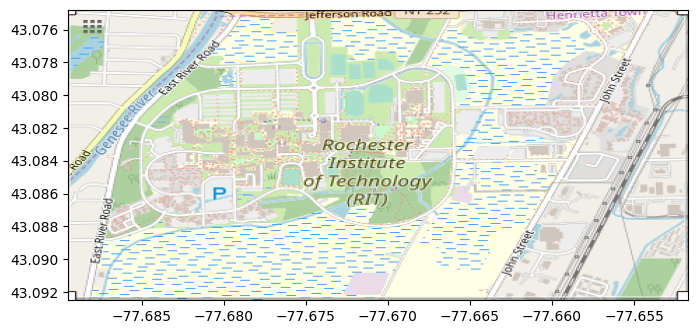

In [ ]:
# Get Vehicle Location

# Province Route ID: 4013312
# Evening Campus Route ID: 4013322


import requests

url = "https://transloc-api-1-2.p.rapidapi.com/vehicles.json"

# Province Route ID: 4013312 ; RIT Agency ID: 643
#querystring = {"routes":"4016624","callback":"call","agencies":"643"} # Evening Campus Shuttle
agency_id = 643
querystring = {"callback":"call", "agencies":agency_id}

# querystring = {"routes":"4013312","callback":"call","agencies":"643"}   # Province

headers = {
    'x-rapidapi-host': "transloc-api-1-2.p.rapidapi.com",
    'x-rapidapi-key': "c7a9a279b1msh49ce82192ac5ef8p1830cejsnf6c553ccadea"
    }


response = requests.request("GET", url, headers=headers, params=querystring)

# print(response.text)
# print(response.headers)
json = response.json()
print(json)


# RIT Agency ID: 643
# Get the vehicle Location
location = (json['data']['643'][0]['location'])
print("Location: " + str(location))

lat = location['lat']   # Get vehicle Latitude
print("Latitude: " + str(lat))

lon = location['lng']   # Get vehicle Longitude
print("Longitude: " + str(lon))

map = plt.imread('Agency location/map.png')
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(lon, lat, zorder=1, alpha= 0.2, c='b', s=10)
BBox = [-77.6895, -77.6517, 43.0925, 43.0748]
ax.imshow(map, zorder=0, extent = BBox, aspect= 'equal')


###Create necessary utility functions and the scheduling model

In [ ]:
import requests
import time
import datetime

# ---------------------------------#
def get_routes(agency_id):
    url = "https://transloc-api-1-2.p.rapidapi.com/routes.json"

    # RIT Agency ID: 643
    querystring = {"callback":"call","agencies":agency_id}

    headers = {
        'x-rapidapi-host': "transloc-api-1-2.p.rapidapi.com",
        'x-rapidapi-key': "c7a9a279b1msh49ce82192ac5ef8p1830cejsnf6c553ccadea"
        }

    response = requests.request("GET", url, headers=headers, params=querystring)
    # print(response.text)

    json = response.json()
    # print(json)

    routes = json['data']['643']    # Get the different routes for RIT(643)
    # print("Number of Routes: " + str(len(routes)))


    # Get the data for each route
    route_name = []
    route_id = []
    for route in routes:
        route_name.append(route['long_name'])
        route_id.append(route['route_id'])
    # print(route_name,route_id)

    # Print route_id for each route
    # for route in range(len(routes)):
    #     # print(route_name[route] + ": " + route_id[route])
    return route_name, route_id


# -----------------------------------------------------------------------------#
def get_vehicles(route_id,agency_id):
    url = "https://transloc-api-1-2.p.rapidapi.com/vehicles.json"

    # Province Route ID: 4013312 ; RIT Agency ID: 643
    # querystring = {"routes":"4013312","callback":"call","agencies":"643"}
    querystring = {"routes":route_id,"callback":"call","agencies":agency_id}

    headers = {
        'x-rapidapi-host': "transloc-api-1-2.p.rapidapi.com",
        'x-rapidapi-key': "c7a9a279b1msh49ce82192ac5ef8p1830cejsnf6c553ccadea"
        }


    response = requests.request("GET", url, headers=headers, params=querystring)

    # print(response.text)
    # print(response.headers)
    json = response.json()
    # print(json)

    # RIT Agency ID: 643
    # Get the passenger_load for the Bus
    passenger_load = (json['data']['643'][0]['passenger_load'])
    passenger_load = round(passenger_load,2) * 100  # Convert to Percentage
    print("Pasenger Load: " + str(passenger_load) + "%")



# -----------------------------------------------------------------------------#
def get_available_vehicles(route_id,agency_id,route_name):
    url = "https://transloc-api-1-2.p.rapidapi.com/vehicles.json"

    # Province Route ID: 4013312 ; RIT Agency ID: 643
    # querystring = {"routes":"4013312","callback":"call","agencies":"643"}
    querystring = {"routes":route_id,"callback":"call","agencies":agency_id}

    headers = {
        'x-rapidapi-host': "transloc-api-1-2.p.rapidapi.com",
        'x-rapidapi-key': "c7a9a279b1msh49ce82192ac5ef8p1830cejsnf6c553ccadea"
        }


    response = requests.request("GET", url, headers=headers, params=querystring)

    # print(response.text)
    # print(response.headers)
    json = response.json()
    # print(json)

    # Get rate limit
    rate_limit = (json['rate_limit'])
    # print("Rate Limit: " + str(rate_limit))

    # Check if the route is active or not. i.e. if data for the route is available.
    route_status = len((json['data']))
    if route_status>0:
        # RIT Agency ID: 643
        # Get the passenger_load for the Bus
        # passenger_load = (json['data']['643'][0]['passenger_load'])
        # passenger_load = round(passenger_load,2) * 100  # Convert to Percentage
        # print(str(route_name) + "Pasenger Load: " + str(passenger_load) + "%")

        passenger_load = (json['data']['643'][0]['passenger_load'])
        passenger_load = round(passenger_load,3) * 100  # Convert to Percentage
        # print(str(route_name) + "Pasenger Load: " + str(passenger_load) + "%")
        return passenger_load, rate_limit
    else:
        passenger_load = 0  # Route Inactive. Hence set passenger_load to 0.
        return passenger_load, rate_limit



# -----------------------------------------------------------------------------#
# Make a list of passenger_load for both active and inactive route/vehicles
def passenger_load_list(route_id_list,agency_id,route_name_list):
    passenger_load_list = []
    for route_id in route_id_list:
        route_name = route_name_list[route_id_list.index(route_id)]
        passenger_load, rate_limit = get_available_vehicles(route_id,agency_id,route_name)
        if passenger_load == None:
            passenger_load_list.append(0)
        else:
            passenger_load_list.append(passenger_load)
        time.sleep(rate_limit*1.1)  # Limit API requests to the rate_limit times 1.1

    # print("passenger_load_list",passenger_load_list)
    return passenger_load_list

# -----------------------------------------------------------------------------#
# Return the current date and time
def get_current_datetime():
    dt = datetime.datetime.today()
    day = dt.day
    mon = dt.month
    yr = dt.year
    hr = dt.hour
    min = dt.minute
    sec = dt.second
    today_datetime = [day, mon, yr, hr, min, sec]
    # today_datetime.extend((day, mon, yr, hr, min, sec))
    return today_datetime


#Construct dataset with OpenAPI

In [ ]:
df = pd.read_csv('Dataset/data.csv', skiprows= 0)
df['date'] = pd.to_datetime(df[['Month','Day','Year', 'Hour', 'Minute', 'Second']]) # Convert individual date/time cols to single datetime
df['date'] = df['date'].dt.strftime('%H:%M')
df = df.drop(columns=['Month','Day','Year', 'Hour', 'Minute', 'Second'])    # Deleting unecessay Date/Time cols
# print(df.head(5))
df

,Weekend RIT Inn,Weekend Retail #2,Weekend Retail #1,date
0,7.1,7.4,0.0,18:06
1,7.1,5.9,0.0,18:06
2,7.1,5.9,0.0,18:07
3,7.1,5.9,0.0,18:07
4,7.1,5.9,0.0,18:07
...,...,...,...,...
606,3.6,0.0,1.5,22:40
607,3.6,0.0,1.5,22:41
608,3.6,0.0,1.5,22:41
609,3.6,0.0,1.5,22:42


In [ ]:

df = pd.read_csv('Dataset/data.csv', skiprows= 0)
df['date'] = pd.to_datetime(df[['Month','Day','Year', 'Hour', 'Minute', 'Second']]) # Convert individual date/time cols to single datetime
# df = df.set_index(['date']) # Set the DateTime column to the index
df = df.drop(columns=['Month','Day','Year', 'Hour', 'Minute', 'Second'])    # Deleting unecessay Date/Time cols
# print(df.head(5))

# df1 = df.resample(rule='35Min', on='date').mean()
# # df1 = df1.set_index('date', drop=False)
# # df1 = df1.between_time('0:00','23:59')
# # print(df1.head(5))
# print(df1)

# Weekend RIT Inn
dfwri = df.drop(columns=['Weekend Retail #1','Weekend Retail #2'])
dfwri = dfwri.set_index('date', drop=False)
dfwri = dfwri.between_time('7:00','1:40')
dfwri = dfwri.resample(rule='35Min', on='date').mean()
print(dfwri)

# # Weekend Retail 1
dfwr1 = df.drop(columns=['Weekend RIT Inn','Weekend Retail #2'])
dfwr1 = dfwr1.set_index('date', drop=False)
dfwr1 = dfwr1.between_time('9:45','22:53')
dfwr1 = dfwr1.resample(rule='87Min', on='date').mean()
print(dfwr1)

# # Weekend Retail 2
dfwr2 = df.drop(columns=['Weekend RIT Inn','Weekend Retail #1'])
dfwr2 = dfwr2.set_index('date', drop=False)
dfwr2 = dfwr2.between_time('10:30','22:11')
dfwr2 = dfwr2.resample(rule='87Min', on='date').mean()
print(dfwr2)



dfwr3 = df.drop(columns=['Weekend Retail #1','Weekend Retail #2'])
dfwr3 = dfwr3.set_index('date', drop=False)
dfwr3 = dfwr3.between_time('7:00','1:40')
dfwr3 = dfwr3.resample(rule='35Min', on='date').mean()
print(dfwr3)




                     Weekend RIT Inn
date                                
2020-02-01 18:05:00        18.155682
2020-02-01 18:40:00         7.153465
2020-02-01 19:15:00         2.405000
2020-02-01 19:50:00         6.912245
2020-02-01 20:25:00         5.734568
2020-02-01 21:00:00         2.648000
2020-02-01 21:35:00         0.276923
2020-02-01 22:10:00         1.492683
                     Weekend Retail #1
date                                  
2020-02-01 17:24:00          11.472500
2020-02-01 18:51:00          13.018548
2020-02-01 20:18:00           6.310000
2020-02-01 21:45:00           1.124096
                     Weekend Retail #2
date                                  
2020-02-01 17:24:00          12.933333
2020-02-01 18:51:00           9.998790
2020-02-01 20:18:00           6.645625
2020-02-01 21:45:00           2.044186
                     Weekend RIT Inn
date                                
2020-02-01 18:05:00        18.155682
2020-02-01 18:40:00         7.153465
2020-02-01 19:

In [ ]:
# Weekend RIT Inn
dfwri = df.drop(columns=['Weekend Retail #1','Weekend Retail #2'])
dfwri = dfwri.set_index('date', drop=False)
dfwri_1 = dfwri.resample(rule='1Min', on='date').mean()
dfwri_5 = dfwri.resample(rule='5Min', on='date').mean()
dfwri_35 = dfwri.resample(rule='35Min', on='date').mean()

vec1 = dfwri_1['Weekend RIT Inn']
vec2 = dfwri_5['Weekend RIT Inn']
vec3 = dfwri_35['Weekend RIT Inn']
#fig, ax = plt.subplots()
# sns.heatmap([vec1])
# plt.show()
# YlGnBu


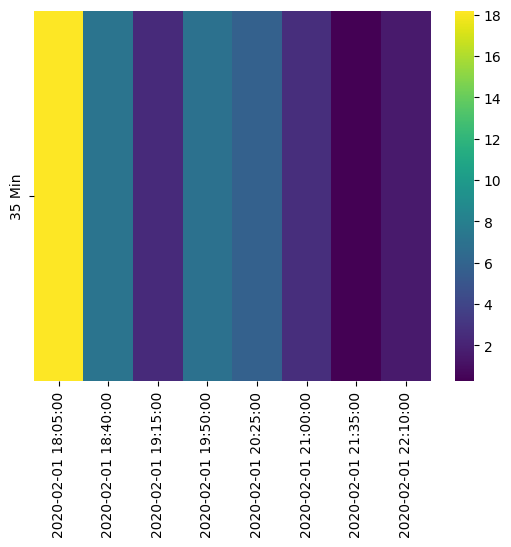

In [ ]:
ax = sns.heatmap([vec3], xticklabels = dfwri_35.index, yticklabels= ["35 Min"],cmap="viridis")
plt.show()

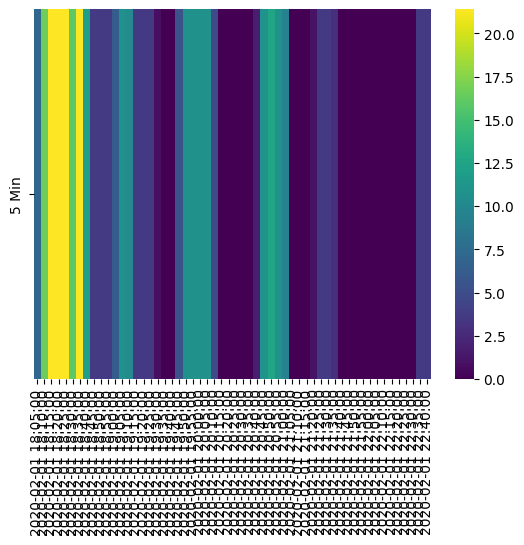

In [ ]:
ax = sns.heatmap([vec2], xticklabels = dfwri_5.index, yticklabels= ["5 Min"],cmap="viridis")
plt.show()

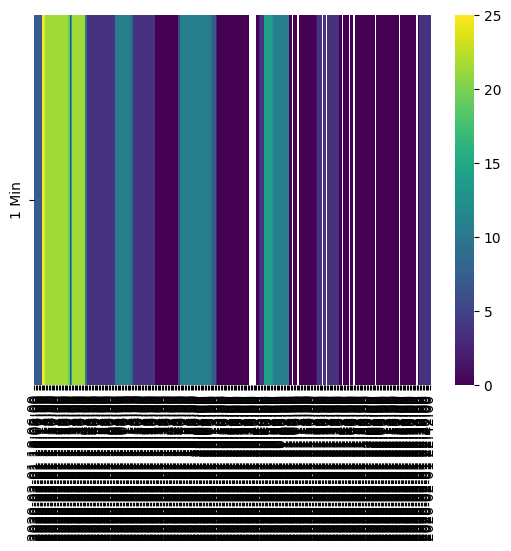

In [ ]:
ax = sns.heatmap([vec1], xticklabels = dfwri_1.index, yticklabels= ["1 Min"],cmap="viridis")
plt.show()

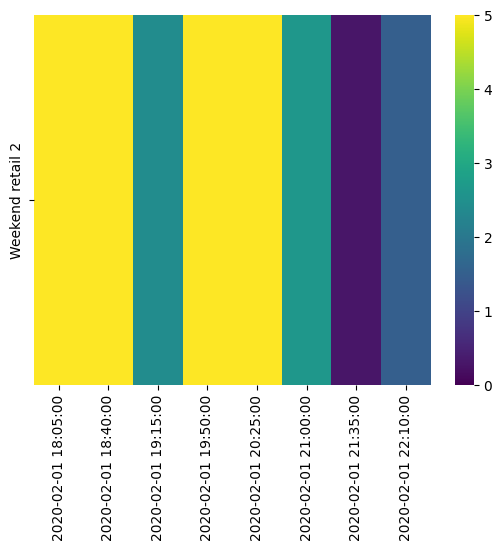

In [ ]:
vec1 = dfwr3['Weekend RIT Inn']
fig, ax = plt.subplots()
# sns.heatmap([vec1])
# plt.show()
# YlGnBu
ax = sns.heatmap([vec1], xticklabels = dfwr3.index, yticklabels= ["Weekend retail 2"],cmap="viridis", vmin=0, vmax=5)
plt.show()

#Test the scheduling model

In [ ]:
import requests
import time
import datetime
import csv

agency_id = 643 # RIT Agency ID
route_name_list, route_id_list = get_routes(agency_id)

# print("Routes:",route_name)
# print("Route ID:",route_id)

# Get a list of passenger_load's for all buses(active and inactive)
# passenger_load_list = passenger_load_list(route_id_list,agency_id,route_name_list)


# today = get_current_datetime()
# print(today)

# Create first line of csv sheet
header = ['Day','Month','Year','Hour','Min','Sec']
header.extend(route_name_list)
print(header)


def create_row(agency_id):
    route_name_list, route_id_list = get_routes(agency_id)
    passenger_loads = passenger_load_list(route_id_list,agency_id,route_name_list)
    today = get_current_datetime()
    # print(today)

    # Create a single list with Current Date, Time and passenger_load
    today.extend(passenger_loads)
    row = today
    print(row)
    return row,today

# create_row(agency_id)

with open('test.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    count = 0;
    while(1):
        count = count + 1
        print(count)
        rownow,today  = create_row(agency_id)
        writer.writerow(rownow)
        #if(today[3]==18 & today[4]==10):
        if(count==10):
            break;
            


['Day', 'Month', 'Year', 'Hour', 'Min', 'Sec', 'Fringe Festival', 'Special', '12-Retail Weekend', '14-RIT Inn Weekend', '1-Off Campus', '6- 175 Jeff. - Park Point - Prov', '15- RIT Inn Evening', '5-Province', '4-Perkins Green', '3- Park Point/175 Jefferson', '2-Apex', '10-Jefferson/Perk/P.Point', '9-Apex/Province', '7- RIT Inn 1', '11-Campus Shuttle', 'AV Run', '8- RIT Inn 2', '13-Campus Weekend']
1


KeyboardInterrupt: ignored

In [ ]:
import pandas as pd
from google.colab import data_table
data_table.enable_dataframe_formatter()

test_data = pd.read_csv("test.csv")
display(test_data)

,Day,Month,Year,Hour,Min,Sec,Fringe Festival,Special,12-Retail Weekend,14-RIT Inn Weekend,...,4-Perkins Green,3- Park Point/175 Jefferson,2-Apex,10-Jefferson/Perk/P.Point,9-Apex/Province,7- RIT Inn 1,11-Campus Shuttle,AV Run,8- RIT Inn 2,13-Campus Weekend


In [26]:
df = pd.read_csv('Bus-Schedule-Optimization/TestData/test.csv', skiprows= 0)
df['date'] = pd.to_datetime(df[['Month','Day','Year', 'Hour', 'Minute', 'Second']]) # Convert individual date/time cols to single datetime
df = df.drop(columns=['Month','Day','Year', 'Hour', 'Minute', 'Second'])    # Deleting unecessay Date/Time cols
# print(df.head(5))
df



,Park Point,Perkins Green,B LOT / Campus Shuttle,Weekend RIT Inn,Province,Perkins - Parkpoint,Weekend Early Morning Shuttle,Supplemental Eastside,RIT Inn,Evening Campus Shuttle,RIT Express 1,RIT Express 2,Weekend Retail #2,Weekend Retail #1,Accesible Van,date
0,0,0,0,7.1,0,0,0,0,0,0,0,0,7.4,0.0,0,2020-02-01 18:06:35
1,0,0,0,7.1,0,0,0,0,0,0,0,0,5.9,0.0,0,2020-02-01 18:06:57
2,0,0,0,7.1,0,0,0,0,0,0,0,0,5.9,0.0,0,2020-02-01 18:07:17
3,0,0,0,7.1,0,0,0,0,0,0,0,0,5.9,0.0,0,2020-02-01 18:07:38
4,0,0,0,7.1,0,0,0,0,0,0,0,0,5.9,0.0,0,2020-02-01 18:07:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0,0,0,3.6,0,0,0,0,0,0,0,0,0.0,1.5,0,2020-02-01 22:40:45
607,0,0,0,3.6,0,0,0,0,0,0,0,0,0.0,1.5,0,2020-02-01 22:41:06
608,0,0,0,3.6,0,0,0,0,0,0,0,0,0.0,1.5,0,2020-02-01 22:41:27
609,0,0,0,3.6,0,0,0,0,0,0,0,0,0.0,1.5,0,2020-02-01 22:42:05


In [23]:
# Weekend RIT Inn
dfwri = df.drop(columns=['Weekend Retail #1','Weekend Retail #2'])
dfwri = dfwri.set_index('date', drop=False)
dfwri_1 = dfwri.resample(rule='1Min', on='date').mean()
dfwri_5 = dfwri.resample(rule='5Min', on='date').mean()
dfwri_35 = dfwri.resample(rule='35Min', on='date').mean()

vec1 = dfwri_1['Weekend RIT Inn']
vec2 = dfwri_5['Weekend RIT Inn']
vec3 = dfwri_35['Weekend RIT Inn']

In [30]:
# Optimized
dfo= df.set_index('date', drop=False)
dfo_1 = dfo.resample(rule='1Min', on='date').mean()
dfo_5 = dfo.resample(rule='5Min', on='date').mean()
dfo_35 = dfo.resample(rule='35Min', on='date').mean()

vec1_o = dfo_1['Weekend Retail #1']
vec2_o = dfo_5['Weekend Retail #1']
vec3_o = dfo_35['Weekend Retail #1']

<h3>35 min bin optimized vs orginal</h3>

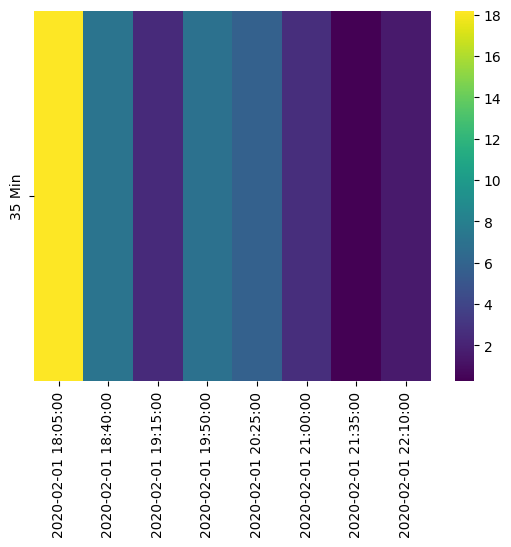

In [32]:
ax = sns.heatmap([vec3], xticklabels = dfwri_35.index, yticklabels= ["35 Min"],cmap="viridis")
plt.show()

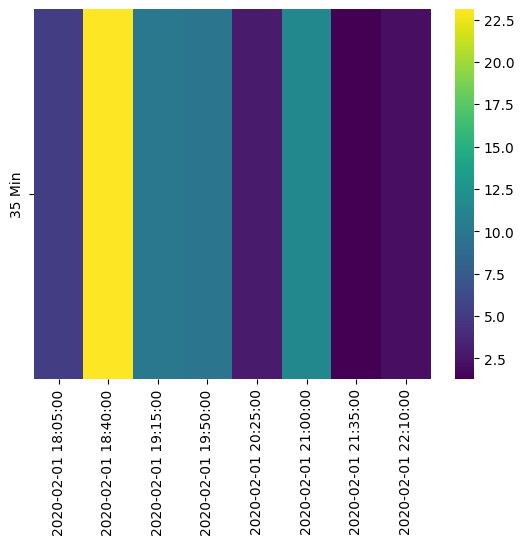

In [33]:
ax = sns.heatmap([vec3_o], xticklabels = dfo_35.index, yticklabels= ["35 Min"],cmap="viridis")
plt.show()

<h3>5 min bin optimized vs orginal</h3>

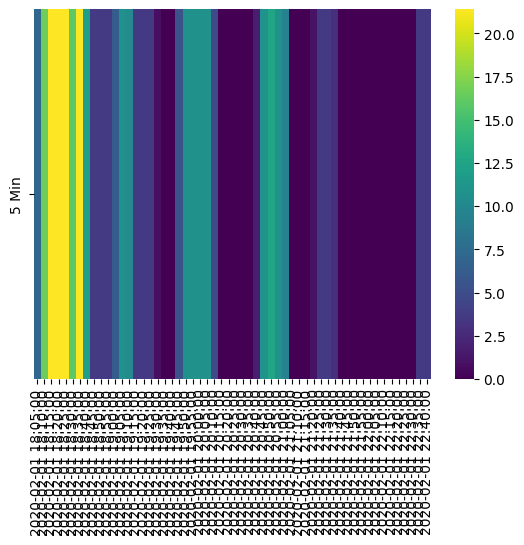

In [34]:
ax = sns.heatmap([vec2], xticklabels = dfwri_5.index, yticklabels= ["5 Min"],cmap="viridis")
plt.show()

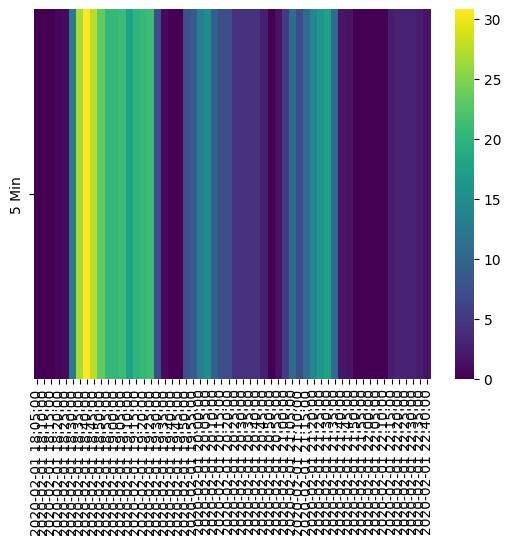

In [35]:
ax = sns.heatmap([vec2_o], xticklabels = dfo_5.index, yticklabels= ["5 Min"],cmap="viridis")
plt.show()

<h3>1 min bin optimized vs orginal</h3>

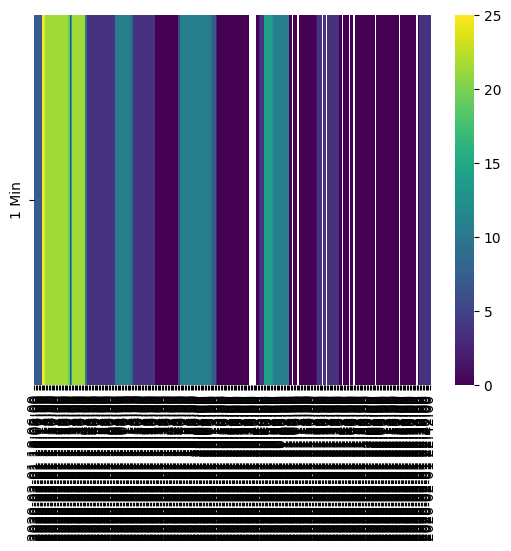

In [36]:
ax = sns.heatmap([vec1], xticklabels = dfwri_1.index, yticklabels= ["1 Min"],cmap="viridis")
plt.show()

In [37]:
ax = sns.heatmap([vec1_o], xticklabels = dfo_1.index, yticklabels= ["1 Min"],cmap="viridis")
plt.show()